## SOLUTION: ODE challenge 1

In [7]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC

First read in data:

In [2]:
data = pd.read_csv("ode_challenge_1_data.csv")

t_data = data["timestamp"]
x_data = data["value"]

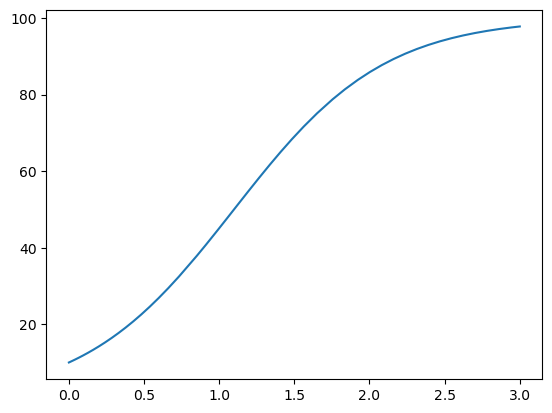

In [3]:
plt.plot(t_data,x_data)
plt.show()

### "By Hand" solution

To solve this problem, we can sweep over different values of $\varepsilon$, using our model to produce results for each one. Then we'll compare these results to the true data and see which one reproduces the original data the closest.

In [11]:
def diffyqs(X, t, epsilon,capacity=100): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    y = X
    dydt = epsilon*y*(capacity-y)
    return dydt

In [12]:
# initial conditions (could get these from data)
x0_1 = [x_data[0]]

# use time data as time array for solver
t = t_data

# range of values of epsiilon to sweep over
epsilons = np.arange(0.01,0.1,0.01)

#epsilons = [1/n for n in range(50,60)]

# empty list to store solutions
sols = []

In [13]:
# sweep over each value of epsilon and do numerical solution for each
for epsilon in epsilons:
    sols.append(odeint(diffyqs, x0_1, t, args=(epsilon,)))

Now that we have results, let's visualize them:

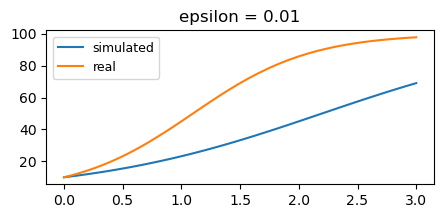

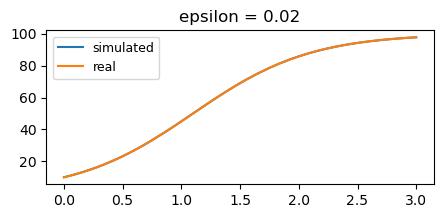

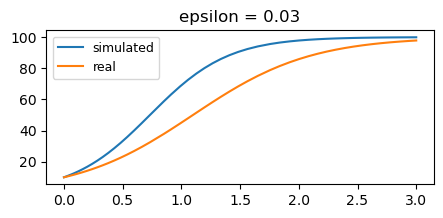

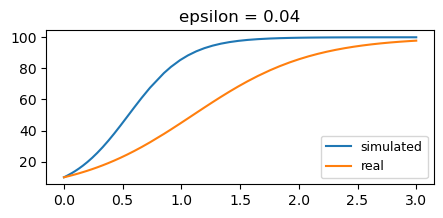

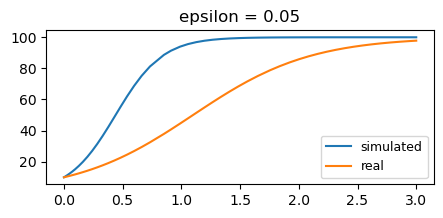

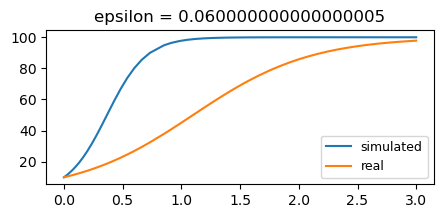

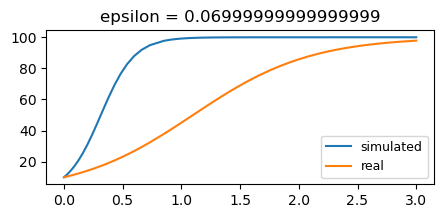

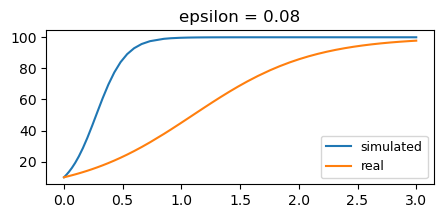

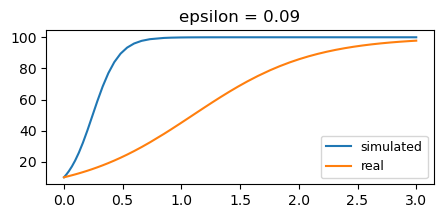

In [14]:
for i, sol in enumerate(sols):
    plt.figure(figsize = (5,2))
    plt.plot(t,sol.T[0], label = "simulated")
    plt.plot(t_data,x_data, label = 'real')
    plt.title('epsilon = ' + str(epsilons[i]))
    plt.legend(fontsize = 9)
    plt.show()

It looks like $\varepsilon = 1/50$ is a good choice. Let's write some code to be a bit more precise about this. We can add up the absolute value of the difference between the simulated and real trajectories to get the cumulative difference between them. The trajectory that minimizes this value will correspond to the best choice of $\varepsilon$

In [15]:
differences = []
for i, sol in enumerate(sols):
    differences.append(sum(np.abs(sol.T[0] - x_data)))

print("the best choice of epsilon is:", epsilons[np.argmin(differences)])

the best choice of epsilon is: 0.02


grace confirmed that this was the correct value =) Now Let's solve the problem again but with PyVBMC

### Solution with PyVBMC

In [18]:
def log_likelihood(theta):
    epsilon,capacity = theta
    sol = odeint(diffyqs, x0_1, t, args=(epsilon,capacity))
    return -np.sum((sol.T[0] - x_data)**2) ## FROM GAUSSIAN

#print(log_likelihood(0.02),log_likelihood(0.022), log_likelihood(0.015),log_likelihood(0.00083),log_likelihood(0.0007))

In [19]:
D = 2  # 2-D since there are 2 params we're estimating

LB = np.full((1, D), 0.0)  # Lower bounds (we know from the model that they have to be positive, negative values would break odeint)
LB[0][0] = 1/100
LB[0][1] = 10
UB = np.full((1, D), 20.0)  # Upper bounds (picked to be reasonable)
UB[0][0] = 1/3
UB[0][1] = 150

PLB = np.copy(LB)# prior_mu - prior_std  # Plausible lower bounds
PLB[0][0] = 1/80
PLB[0][1] = 59  
PUB = np.copy(UB) # prior_mu + prior_std  # Plausible upper bounds 
PUB[0][0] = 1/3
PUB[0][1] = 115

x0 = np.random.uniform(PLB, PUB) # starting point for inference   # 1.5 * np.ones((1, D))

In [20]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB, UB)) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

vbmc:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10       -7818.19      2367.07          inf        2        inf     start warm-up
     1         15       -1166.35      1244.74     14450.36        2        inf     
     2         20          -7.52        28.69       807.84        2    2.3e+04     
     3         25         -13.42         0.00         0.41        2       29.3     
     4         30         -13.40         0.00         0.00        2      0.124     
     5         35         -13.44         0.00         0.00        2      0.204     
     6         40         -13.42         0.00         0.00        2      0.113     
     7         45         -13.42         0.00         0.00        2     0.0459     


c:\Users\walki\.conda\envs\bpe\Lib\site-packages\pyvbmc\vbmc\active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 3. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


     8         50         -13.42         0.01         0.00        2      0.148     end warm-up
     9         55         -14.18         0.01         2.50        2       61.5     
    10         60         -13.68         0.00         1.63        2       40.2     
    11         65         -13.36         0.00         0.18        3       5.33     
    12         70         -13.49         0.00         0.05        4       1.61     
    13         75         -15.57         0.01         0.86        4       27.3     
    14         80         -13.60         0.00         1.13        4       33.1     
    15         85         -13.50         0.00         0.03        4       1.09     
    16         90         -13.73         0.00         0.11        4       3.33     
    17         95         -13.68         0.00         0.14        4       3.44     
    18        100         -13.57         0.00         0.09        4       2.57     
    19        105         -13.47         0.00         0.31       

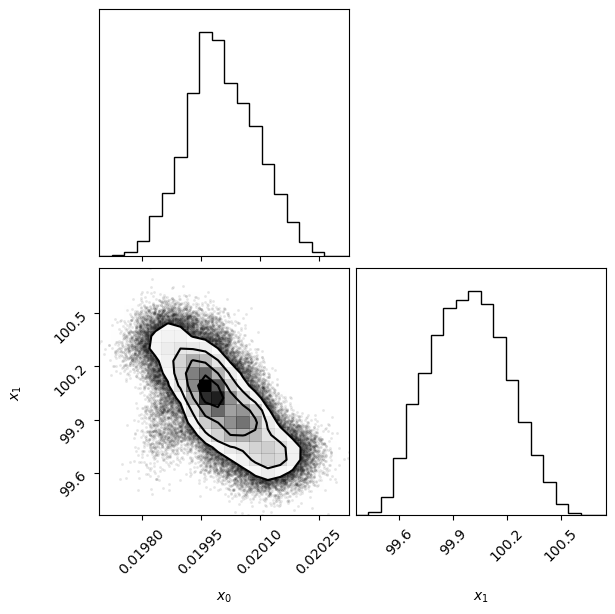

In [21]:
vp.plot();

The approximate posterior mean is: [2.00028065e-02 9.99887973e+01]


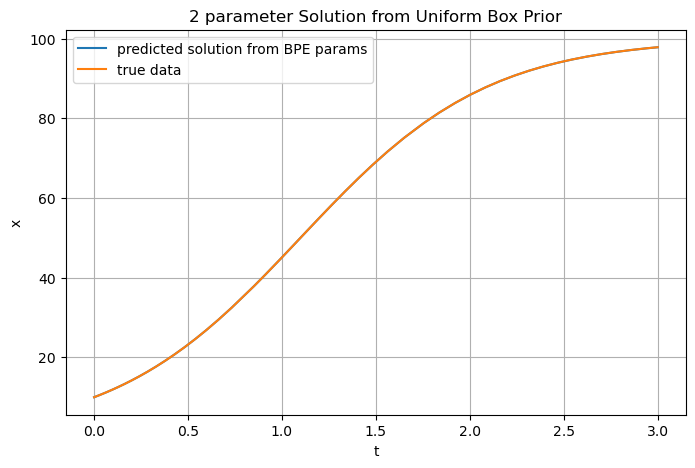

In [26]:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

post_mean = np.mean(Xs, axis=0)  # Posterior mean
print("The approximate posterior mean is:", post_mean)


epsilon =  post_mean[0]
capacity = post_mean[1]

sol = odeint(diffyqs, x0_1, t, args=(epsilon,capacity))

plt.figure(figsize=(8,5))
plt.title("2 parameter Solution from Uniform Box Prior")
plt.plot(t,sol.T[0], label = "predicted solution from BPE params")
plt.plot(t,x_data, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()